# Task00 - Data Ingestion
## Introduction -
 * The goal of this project is to use multiple types of field collected data to describe how different types of corn genotypes respond to Nitrogen fertilizer.  The types of data are:
    * Leaf level gas exchange data describes the respiratory state of a leaf in terms of the amount of CO2 and H2O. Collected twice per Plot_Year at one time point. 
    * Multispectral remote sensing data describes the amount of Red, Blue, Green, Red Edge, and Near Infrared light reflecting from the canopy of plants. It can be processed into vegetative indices such as NDVI that are associated with the relative "healthiness" of a plant. Collected once per Plot_Year at multiple time points.
    * Point cloud remote sensing data was process the estimate plot heights via subtraction of surface models. Collected once per Plot_Year at multiple time points.
    * Hand collected collected notes about flowering date, kernel yield, and height. Collected once per Plot_Year at one time point.
 * Bringing the data together will require many considerations because it is collected at different scales. 
 * The experimental design is 105 maize genotypes x 2 years x 2 Nitrogen treatments 
## Purpose -
 * Data to be used for this project is a subset of data that contains remote sensing and gas exchange information. The prupose of this notebook is to make that subset from files stored on my OneDrive and save it to this project directory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np

In [2]:
# point-cloud remote sensing 
df_pc = pd.read_csv(r'C:\Users\bdub\OneDrive - Michigan State University\DataWareHouse\CLEANED\RemoteSensingCSVs\RGBAutoHts.csv')
# multispectral reflectance reflectance
df_ref = pd.read_csv(r'C:\Users\bdub\OneDrive - Michigan State University\DataWareHouse\CLEANED\RemoteSensingCSVs\MultiSpec.csv')
# meta data about field plots
df_meta = pd.read_csv(r'C:\Users\bdub\OneDrive - Michigan State University\DataWareHouse\CLEANED\MasterCSVs\MasterMetaData.csv')
df_meta.drop(columns=['FTREATMENT', 'TYPE', 'LOCATION', 'PLANTINGDATE'], inplace=True)
# hand collected agronomy data
df_agro = pd.read_csv(r'C:\Users\bdub\OneDrive - Michigan State University\DataWareHouse\CLEANED\MasterCSVs\MasterAgronData.csv')
# gas excahnge data from Licor
df_gasex = pd.read_csv(r'C:\Users\bdub\OneDrive - Michigan State University\DataWareHouse\CLEANED\MasterCSVs\MasterGasExData.csv')
df_gasex.drop(columns=['date', 'time'], inplace=True)

# formatting
dfs = [df_pc, df_ref, df_agro, df_meta, df_gasex]
for df in dfs:
    df['YEAR'] = df['YEAR'].astype('str')
    df['PLOT'] = df['PLOT'].astype('str')

# Subset those with gas_ex measurements
df_gasex = pd.merge(df_meta, df_gasex, on = ['PLOT_YEAR', 'PLOT', 'YEAR'], how='inner')


### E, A, Ci, gsw
 - E, A, Ci, and gsw are gas exchange parameters collected from a Licor 6800. They were collect on two leaves per plot_year. The ultimate goal for the web app is to draw connections between mltiple sources of data. Those other sources of data were collected on the plot level. Thus We see above that when one value is missing, they all are missing. 
 - Our ultimate goal is to produce plot level measur


Text(0.5, 1.0, 'Missing After Aggregate')

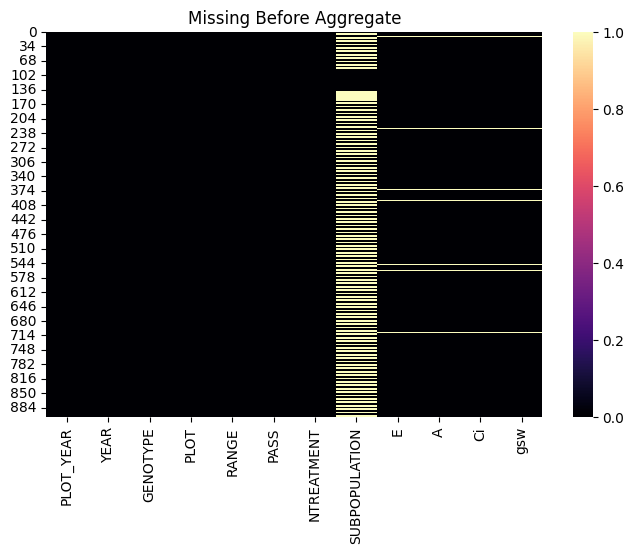

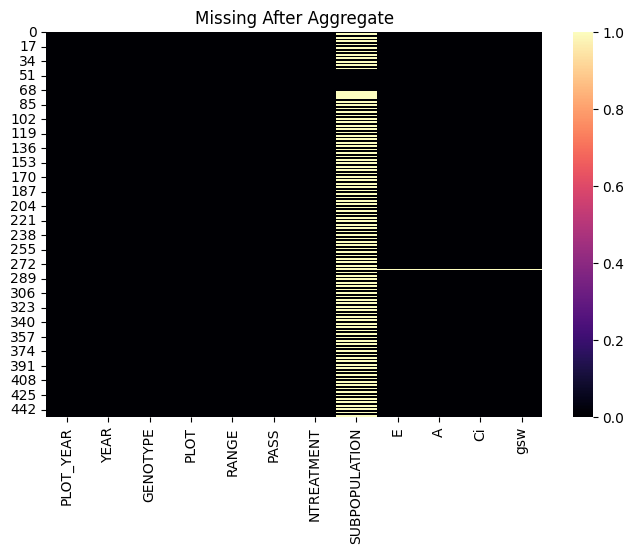

In [3]:
# before aggregating
plt.figure(figsize=(8, 5))
sns.heatmap(df_gasex.isna(), cmap="magma")
plt.title('Missing Before Aggregate')

# list of cols to calc mean
cols = list(df_gasex.columns[8:])
cols.append('PLOT_YEAR')
df_gasex_g = df_gasex[cols]
# calc mean based on unique PLOT_YEAR
df_gasex_g = df_gasex_g.groupby(by='PLOT_YEAR').mean().reset_index()

# Merge it back with meta data
df_gasex_g = pd.merge(df_meta, df_gasex_g, on = 'PLOT_YEAR', how='inner')

# plot after 
plt.figure(figsize=(8, 5))
sns.heatmap(df_gasex_g.isna(), cmap="magma")
plt.title('Missing After Aggregate')

In [4]:
# taking mean of plot_level resolved all missing except for one.
print(df_gasex_g.loc[df_gasex_g['A'].isna(),:])
# Not sure why this sample is missing let's look at yield and flowering

     PLOT_YEAR  YEAR GENOTYPE  PLOT  RANGE  PASS NTREATMENT SUBPOPULATION   E  \
278  7103_2023  2023    ND249  7103      7    20          L           NaN NaN   

      A  Ci  gsw  
278 NaN NaN  NaN  


### Fill in missing values of subpopulation based on genotype replications
 - "Subpopulation" is a categorical variable that informs us about the origin of a genotype. The subpopulation for a genotype never changes. The mechanism of missingness is MAR because it was not recorded for one of the years of study. Fortunately it is easy to rectify because we can fill in values based on the other year. I'm not 100% sure what exactly type of imputation this would be labeled as, something like filling in with the mean or mode. To help write the code I used Claude 3.5 Sonnet on 10/12/24 with the following prompt "If I have a pandas dataframe with column genotype and subpopulation with replication and some values of genotype have subpopulation information but others don't how can I fill in missing values based on the replicates that do have subpopulation ?" To which it provided, and I modified 
    - df['subpopulation'] = df.groupby(['genotype', 'replicate'])['subpopulation'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
- This solution works by grouping by genotype then applying an anonymous function lambda to the 'subpopulation' column that forward fills and then backward fills NA values

Text(0.5, 1.0, 'Missing After Fill')

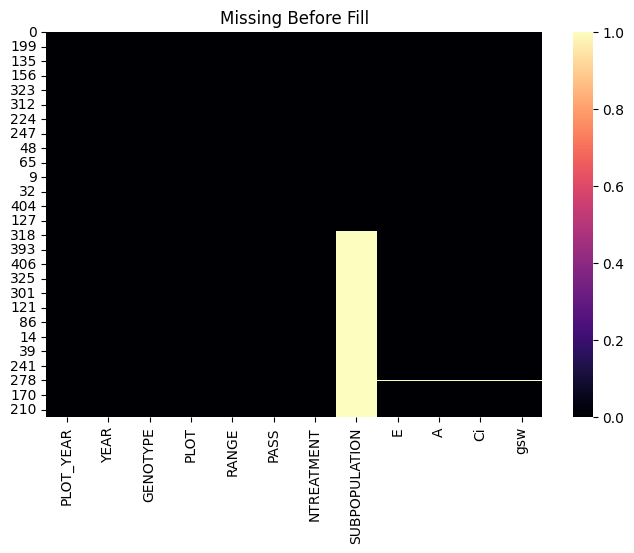

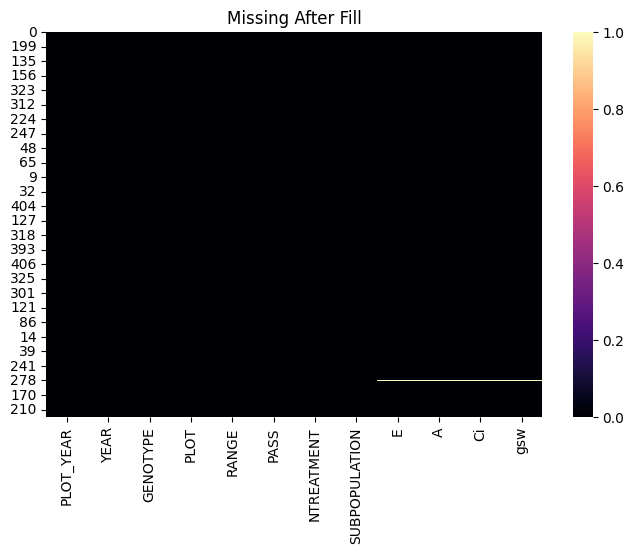

In [5]:
# before fill impution
# sort by year to see MAR
df_gasex_g.sort_values(by='YEAR', inplace=True)
plt.figure(figsize=(8, 5))
sns.heatmap(df_gasex_g.isna(), cmap="magma")
plt.title('Missing Before Fill')

# impute missing
df_gasex_g['SUBPOPULATION'] = df_gasex_g.groupby('GENOTYPE')['SUBPOPULATION'].transform(lambda x: x.fillna(method='ffill').fillna(method='bfill'))

# after 
plt.figure(figsize=(8, 5))
sns.heatmap(df_gasex_g.isna(), cmap="magma")
plt.title('Missing After Fill')

In [6]:
# keys for merging
keys = ['PLOT_YEAR', 'PLOT', 'YEAR']

# merge agronomic traits of interest with gas ex
cols2keep = ['KERNELDRYWT_PERPLANT', 'KERNELMOISTURE_P', 'DAYSTOANTHESIS',
              'DAYSTOSILK', 'ASI', 'AVGFLAGHT_CM'] + keys

df_agro = df_agro.loc[:, cols2keep]

df_gasex_g = pd.merge(df_gasex_g, df_agro, on=keys, how='inner')

YEAR
2023    25
Name: count, dtype: int64


<Axes: >

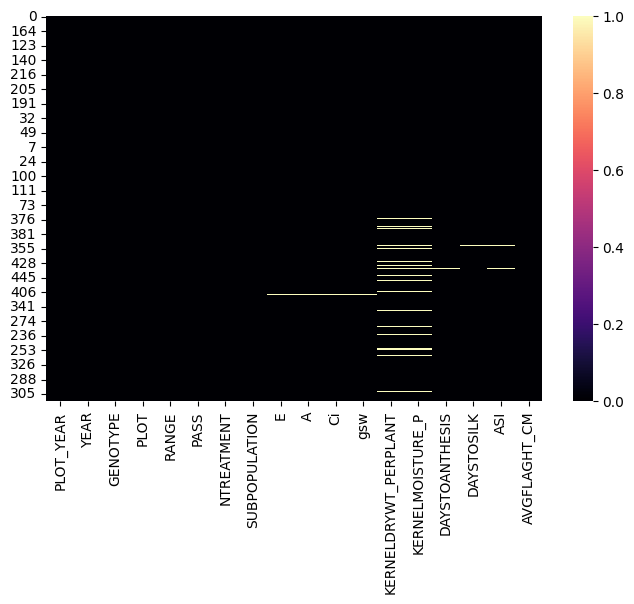

In [7]:
# all of the missing values are from 2023
df_gas_miss = df_gasex_g.loc[df_gasex_g['KERNELDRYWT_PERPLANT'].isna(), :]
print(df_gas_miss['YEAR'].value_counts())

df_gasex_g.sort_values(by='YEAR', inplace=True)
plt.figure(figsize=(8,5))
sns.heatmap(df_gasex_g.isna(), cmap="magma")

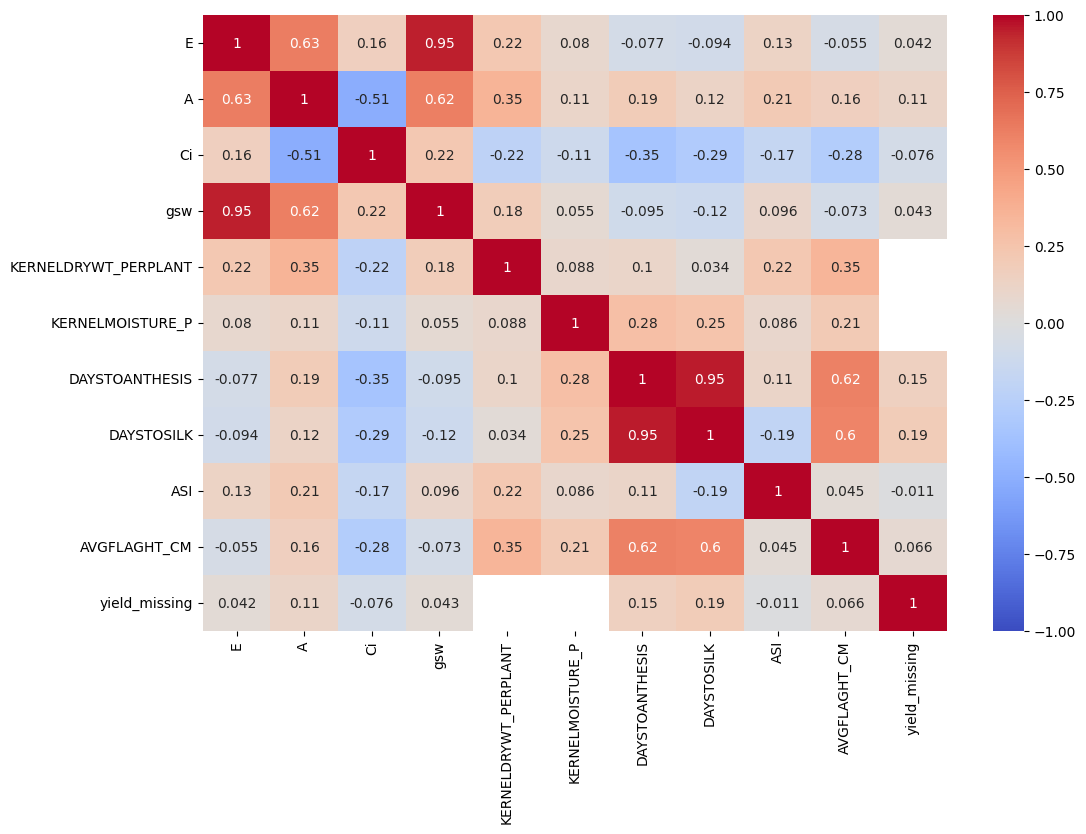

In [8]:
# Assess if the yield missingness is related to any other variable
df_gasex_g['yield_missing'] = df_gasex_g['KERNELDRYWT_PERPLANT'].isna().astype(int)
quantcols = list(df_gasex_g.columns[8:])
plt.figure(figsize=(12,8))
sns.heatmap(df_gasex_g.loc[df_gasex_g['YEAR'] == '2023', quantcols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()
quantcols.remove('yield_missing')
df_gasex_g.drop(columns = 'yield_missing', inplace = True)

### Yield and flowering:
 * There are 25 samples missing yield data from 2023. Besides all being missing from 2023, the missingness does not appear to be strongly correlated with any other field or gas exchange traits considered so far. For these reasons I think yield missingness is either MCAR or MNAR. It is hard to tell between MCAR and MNAR. I will drop missing samples and be wary of making conclusions from year 2023 data because all of the missing data comes from that year. Differences are expected between years because field grown corn are at the mercy of the weather so to speak. However, we can make a pairplot and color code everything by 'YEAR' to look for any abnormalities. 

In [9]:
df_gasex_g = df_gasex_g.dropna()
print(df_gasex_g.isna().sum())

PLOT_YEAR               0
YEAR                    0
GENOTYPE                0
PLOT                    0
RANGE                   0
PASS                    0
NTREATMENT              0
SUBPOPULATION           0
E                       0
A                       0
Ci                      0
gsw                     0
KERNELDRYWT_PERPLANT    0
KERNELMOISTURE_P        0
DAYSTOANTHESIS          0
DAYSTOSILK              0
ASI                     0
AVGFLAGHT_CM            0
dtype: int64


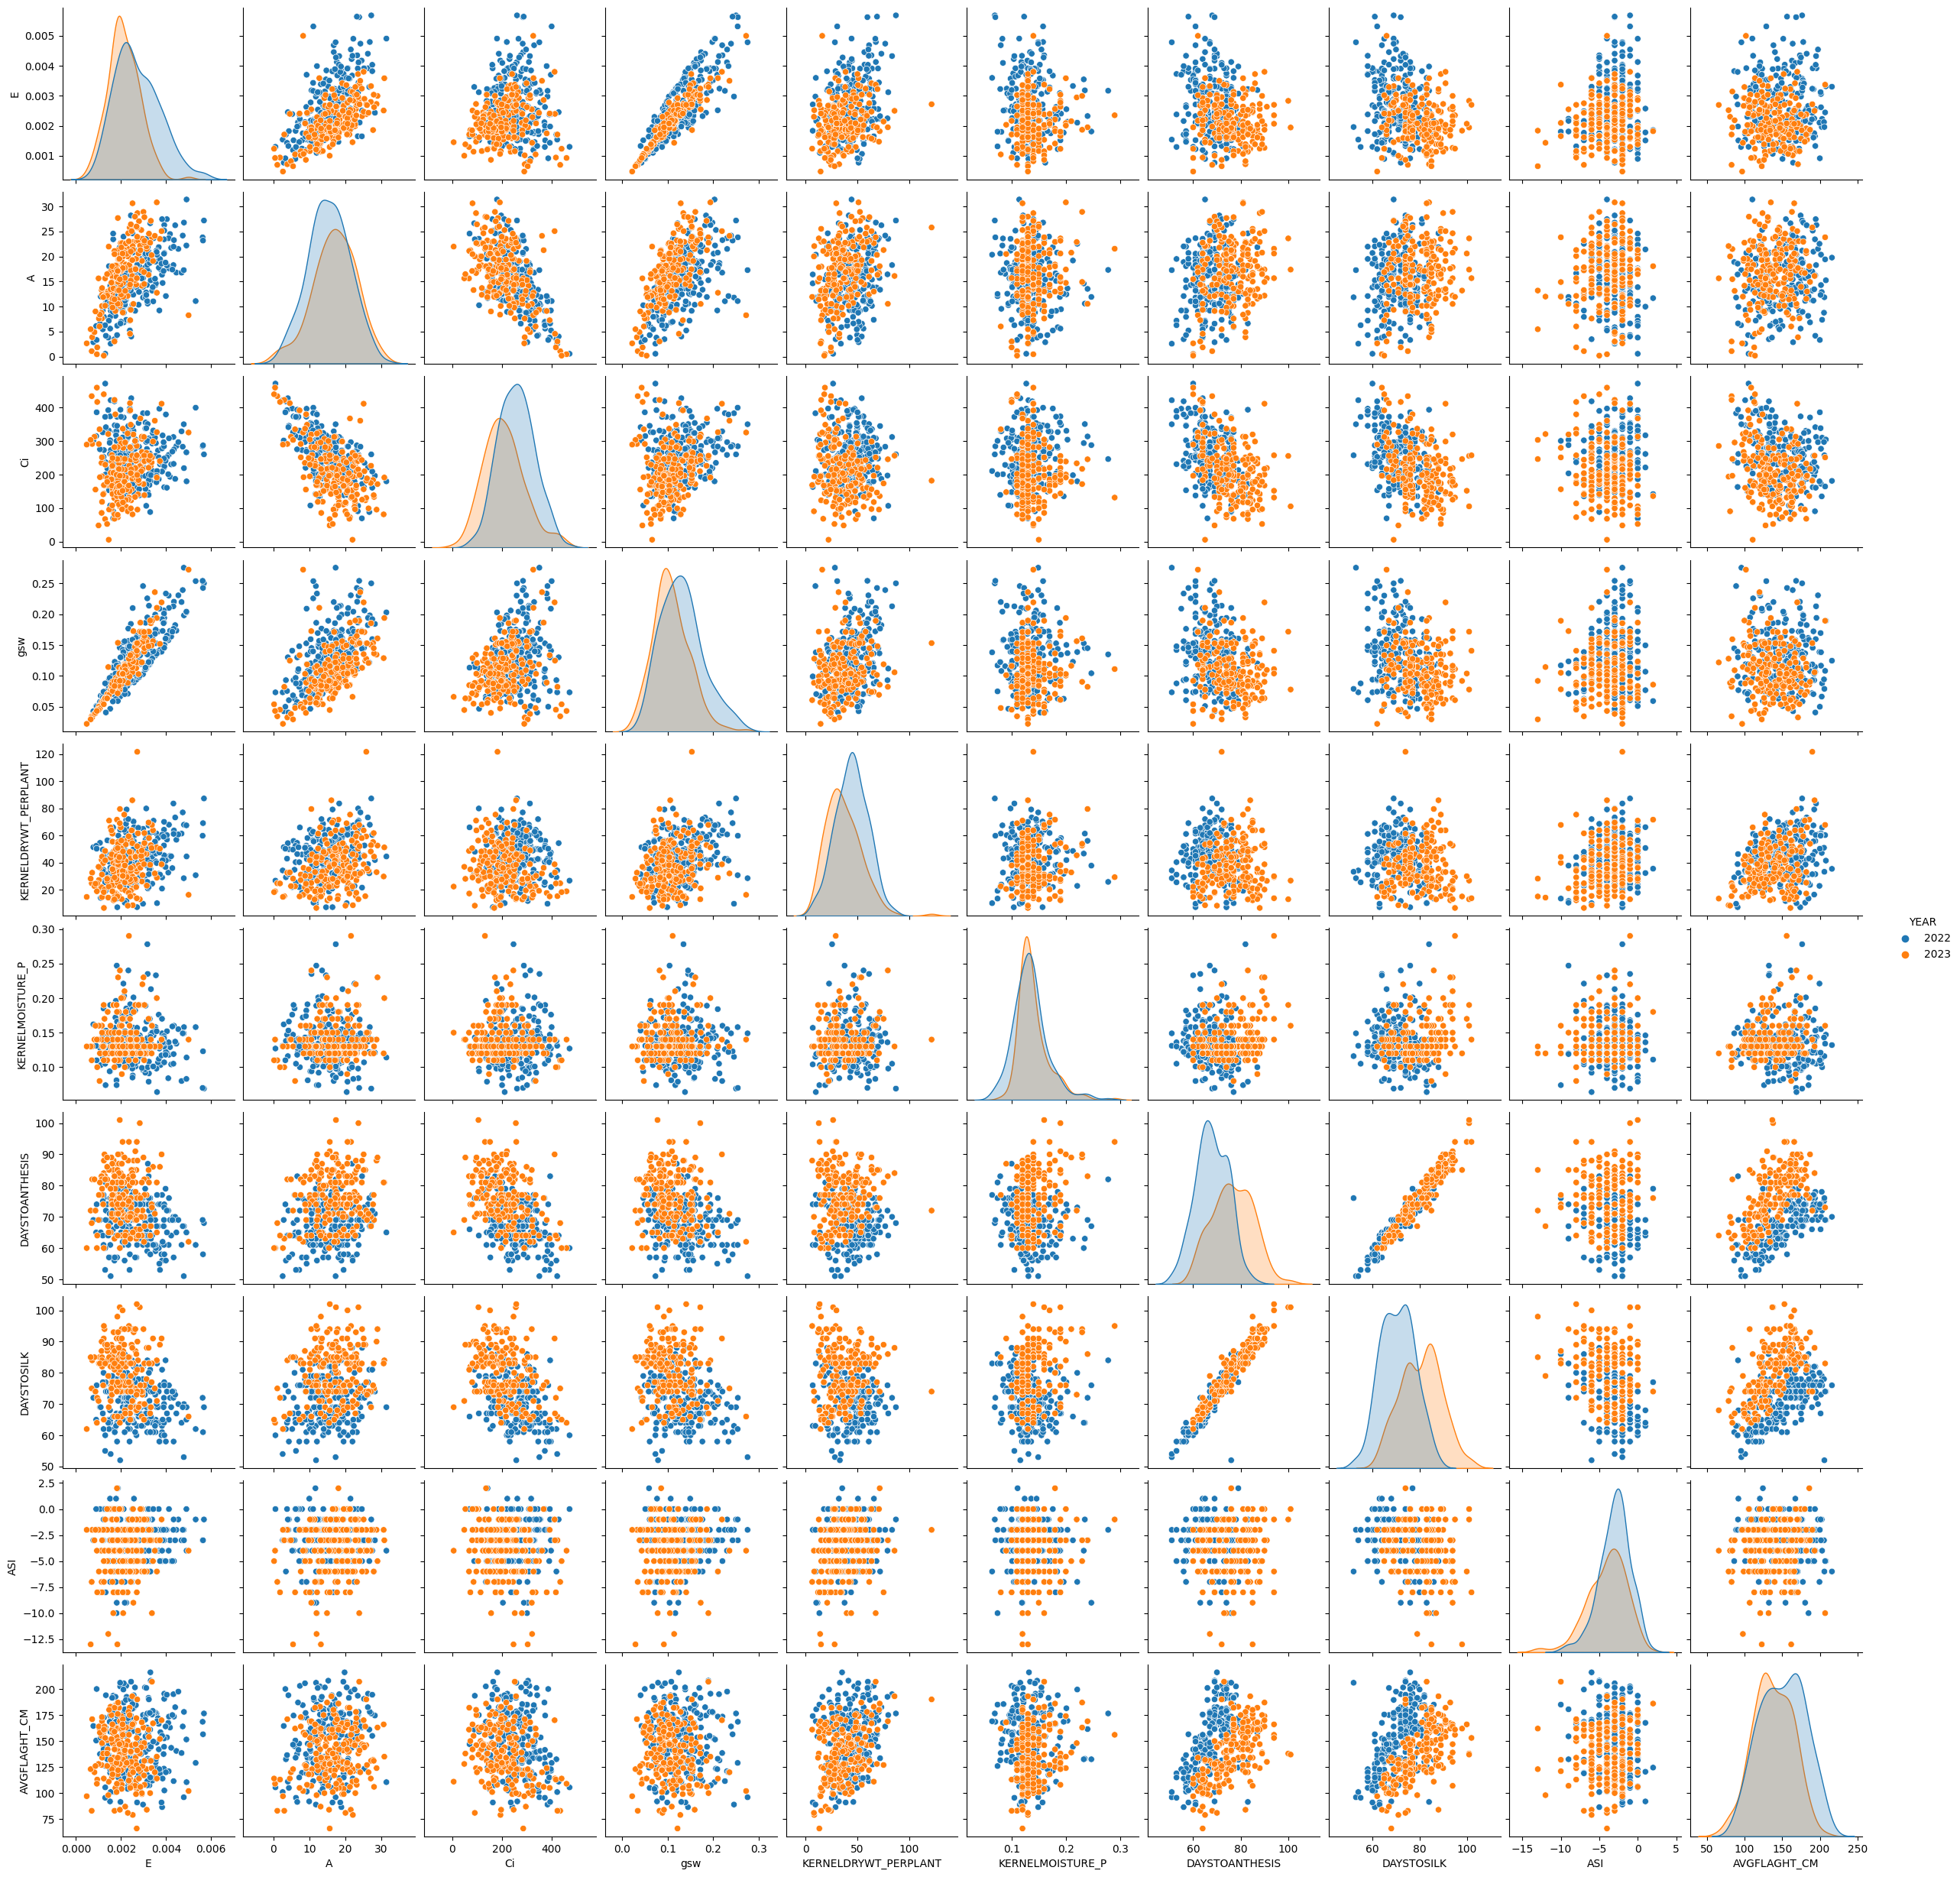

In [10]:
# 
cols2keep = quantcols
cols2keep.append('YEAR')
sns.pairplot(df_gasex_g[cols2keep], hue='YEAR')

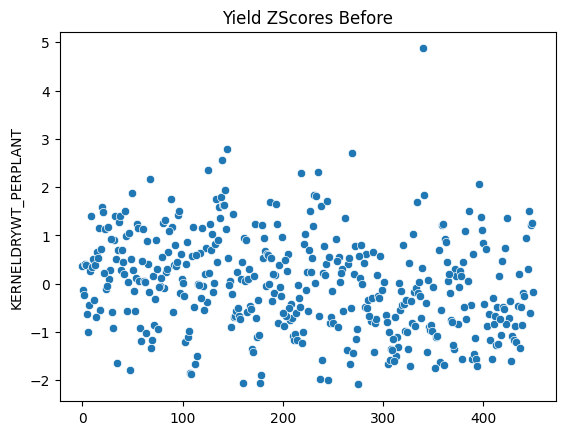

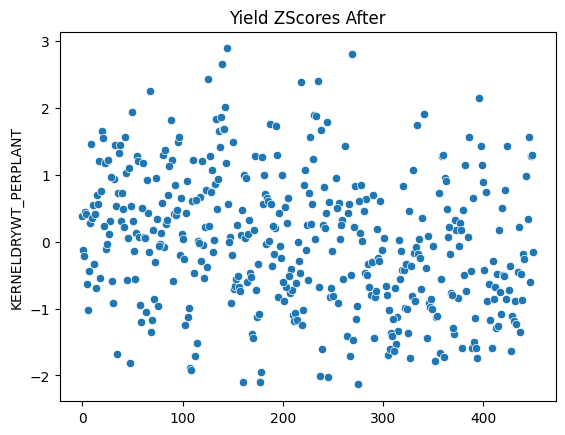

In [11]:
# It looks like 
numeric_cols = df_gasex_g.select_dtypes(include=[np.number]).columns
df_g_s = df_gasex_g[numeric_cols].apply(zscore)

# looks like one point is almost 5 SD above while everything else is > 3, let's remove
sns.scatterplot(data=df_g_s, x= df_g_s.index, y = 'KERNELDRYWT_PERPLANT')
plt.title('Yield ZScores Before')
plt.show()
df_gasex_g = df_gasex_g.loc[df_gasex_g['PLOT_YEAR'] != '7318_2023']

df_g_s = df_gasex_g[numeric_cols].apply(zscore)

# After
sns.scatterplot(data=df_g_s, x= df_g_s.index, y = 'KERNELDRYWT_PERPLANT')
plt.title('Yield ZScores After')
plt.show()

In [40]:
# save for EDA 
#df_gasex_g.to_csv('../Data/PlotFieldData.csv', index=False)

### Point Cloud and Multispectral reflectance
 * There are no missing values for point cloud or multispectral reflectance data
 * 2023 data is to be processed so it can be included in part 2 of project

In [32]:
# Plot_Years of interest
plots2keep = set(df_gasex_g['PLOT_YEAR'].values)
# keys for merging
keys = ['PLOT_YEAR', 'PLOT', 'YEAR']
# select only those plots we are interested in
df_pc = df_pc.loc[df_pc['PLOT_YEAR'].isin(plots2keep)]
df_ref = df_ref.loc[df_ref['PLOT_YEAR'].isin(plots2keep)]

print(df_ref.isna().sum())

PLOT_YEAR    0
PLOT         0
YEAR         0
DAP          0
Band         0
MIN          0
MAX          0
RANGE        0
MEAN         0
STD          0
SUM          0
MEDIAN       0
PCT90        0
dtype: int64


In [33]:
print(df_pc.isna().sum())

PLOT_YEAR    0
PLOT         0
YEAR         0
DAP          0
MIN          0
MAX          0
RANGE        0
MEAN         0
STD          0
SUM          0
MEDIAN       0
PCT5         0
PCT25        0
PCT90        0
PCT99        0
dtype: int64


In [34]:
# The multispectral reflectance data is most useful when processed into vegetative indices 
# Let's make MS table now
# Prepare data
df_ref['ID'] = df_ref['PLOT_YEAR'].astype('str') + "_" + df_ref['DAP'].astype('str')
unmelt = df_ref.pivot(index = 'ID', columns = 'Band', values = 'MEAN').reset_index()
# Just doing this here to move it down later
unmelt['NDVI'] = (unmelt['NIR'] - unmelt['Red']) / (unmelt['NIR'] + unmelt['Red'])
unmelt['GNDVI'] = (unmelt['NIR'] - unmelt['Green']) / (unmelt['NIR'] + unmelt['Green'])
unmelt['RDVI'] = (unmelt['NIR'] - unmelt['Red']) / (np.sqrt(unmelt['NIR'] + unmelt['Red']))
unmelt['NLI'] = ((unmelt['NIR']**2) - unmelt['Red']) / ((unmelt['NIR']**2) + unmelt['Red'])
unmelt['CVI'] = (unmelt['NIR'] * unmelt['NIR']) / (unmelt['Green']**2)
unmelt['MSR'] = ((unmelt['NIR'] / unmelt['Red']) - 1) / ((np.sqrt(unmelt['NIR'] / unmelt['Red'])) + 1)
unmelt['NDI'] = (unmelt['RedEdge'] - unmelt['Red']) / (unmelt['RedEdge'] + unmelt['Red'])
unmelt['NDVIRedge'] = (unmelt['NIR'] - unmelt['RedEdge']) / (unmelt['NIR'] + unmelt['RedEdge'])
unmelt['PSRI'] = (unmelt['Red'] - unmelt['Blue']) / unmelt['RedEdge']
unmelt['CIRedge'] = (unmelt['NIR'] / unmelt['RedEdge']) - 1
unmelt['MTCI'] = (unmelt['NIR'] - unmelt['RedEdge']) / (unmelt['RedEdge'] - unmelt['Red'])

unmelt[['PLOT', 'YEAR', 'DAP']] = unmelt['ID'].str.split(pat = '_', n=2, expand = True)

C:\Users\bdub\AppData\Local\Temp\ipykernel_10484\3090520415.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref['ID'] = df_ref['PLOT_YEAR'].astype('str') + "_" + df_ref['DAP'].astype('str')


In [35]:
df_ref = pd.merge(df_meta, unmelt, on =['PLOT', 'YEAR'], how = 'inner')
df_ref = df_ref.loc[df_ref['PLOT_YEAR'].isin(plots2keep), ]

<Axes: xlabel='DAP', ylabel='CIRedge'>

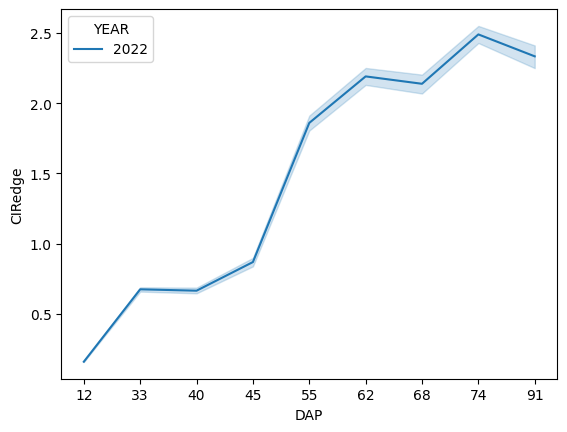

In [36]:
sns.lineplot(data=df_ref, x = 'DAP', y = 'CIRedge', hue = 'YEAR')
plt.show()

In [37]:
df_pc = pd.merge(df_meta, df_pc, on =['PLOT', 'YEAR', 'PLOT_YEAR'], how = 'inner')
df_pc = df_pc.loc[df_pc['PLOT_YEAR'].isin(plots2keep), ]

# need to rename
df_pc.rename(columns={'RANGE_x': 'RANGE', 'RANGE_y':'HtRange'}, inplace=True)

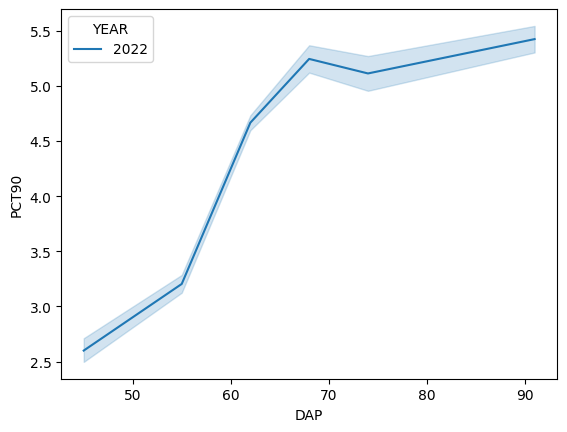

In [39]:
sns.lineplot(data=df_pc, x = 'DAP', y = 'PCT90', hue = 'YEAR')
plt.show()